# What kind of restaurant in Riga?

## Business problem
Given growth of the number of visitors to Riga, there is opportunity for opening new restaurants in Riga. The first thing to be clear about when opening a restaurant is to know what kind of food to serve.

The present investigation seeks to answer the following question of prospective entrepreneurs wanting to open a restaurant in Riga: 

> *What type of restaurant, serving what type of food, is relatively likely to be successful in Riga?*

## Methodology

1. Get a list of museums spread over Europe as points of focus. Reason for taking museums is that these are spots visited by tourists and hence we can expect touristic facilities like restaurants in the vicinity.
2. Get an overview of restaurants near each of these museums from FourSquare.
3. Use K-means to cluster the different areas and analyse the characteristics of the clusters.
4. Compare Riga with other areas within the cluster it falls into.
5. Where a restaurant type is underrepresented in Riga compared to the other places in its cluster, we conclude that there is a relatively good probability that a restaurant of this type can be successful.

## Generic imports
We import the following python libraries.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# !pip3 install geocoder==0.6.0
import geocoder
from geopy import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import pickle
print('Libraries imported.')

Libraries imported.


# 1. Get a list of museums in Europe

Take a start here: https://culturetourist.com/museums/15-best-museums-in-europe-you-have-to-visit-this-year/

Unfortunately, it is hard to find a list of addresses of museums, so we manually go for them. Several museums were added manually later, in order to have a better spread of locations over Europe.

In [2]:
lnma_riga = 'Latvian National Museum of Art, Riga'

museum_addresses_input = {
    'Rijksmuseum, Amsterdam': 'Museumstraat 1, 1071 XX, Amsterdam',
    'Prado Museum, Madrid': 'Paseo del Prado, s/n, 28014, Madrid',
    'Uffizi Gallery, Florence': 'Piazzale degli Uffizi 6, 50122, Florence',
    'Museum of Warsaw': 'Rynek Starego Miasta 28-42, 00-272 Warszawa',
    'National Museum of the Azulejo, Lisbon': (38.7246327,-9.1159956), #The following doesn't work: R. Me. Deus 4, 1900-312 Lisboa, Portugal',
    'Musee Louvre, Paris': 'Rue de Rivoli, 75001, Paris',
    'Acropolis Museum, Athens': 'Dionysiou Areopagitou 15, 117 42, Athens',
    'Hermitage Museum, St. Petersburg': 'Palace Square, 2, St Petersburg, Russia',
    'Vasa Museum, Stockholm': 'Galärvarvsvägen 14, 115 21 Stockholm',
    'Picasso Museum, Barcelona': 'Carrer Montcada, 15-23, 08003 Barcelona, Spain',
    'National Gallery, London': 'Trafalgar Square, United Kingdom',
    'DDR Museum, Berlin': 'Karl-Liebknecht-Str. 1, 10178 Berlin, Germany',
    'Vatican Museums, Rome': 'Viale Vaticano, 00165 Roma RM, Italy',
    'Musée d\'Orsay, Paris': '1 Rue de la Légion d\'Honneur, 75007 Paris, France',
    'Viking Ship Museum, Roskilde': 'Vindeboder 12, 4000 Roskilde, Denmark',
    'Tate Modern, London': 'Bankside, London SE1 9TG, United Kingdom',
    'Peggy Guggenheim Museum, Venice': 'Dorsoduro, 701-704, 30123 Venezia VE, Italy',
    'Museum Ludwig, Cologne': 'Heinrich-Böll-Platz, 50667 Köln, Germany',
    'Musée d\'Art et de Histoire, Genève': 'Rue Charles-Galland 2, 1206 Genève, Switzerland',
    'The Rosengard Collection, Lucerne': 'Pilatusstrasse 10, 6003 Luzern, Switzerland',
    'Musee d\'Art Comtemporani de Barcelona': 'Plaça dels Angels, 1, Barcelona',
    'Museu Coleção Berardo, Lisbon': 'Praça do Império, 1449-003 Lisboa, Portugal',
    'National Gallery Prague, Prague': 'Staroměstské nám., 110 15 Staré Město, Czechia',
    'Pushkin Museum of Fine Art, Moscow': 'Ulitsa Volkhonka 12, Moscow, Russia',
    'Thorvaldsens Museum, Copenhagen': 'Thorvaldsens Museum, Copenhagen, Denmark',
    'Statens Museum for Kunst, Copenhagen': (55.6887927,12.5081192), # Failed to get address
    'The Bohdan and Varvara Khanenko National Museum of Arts, Kiev': (50.4411509,30.5123974),
    lnma_riga: 'Jaņa Rozentāla laukums 1, Rīga'
}

### Read locations of museums

If we have a saved version of the overview of museums with their locations we read it from file.
Otherwise, we use the above list of museums and get their locations from Foursquare.

In [3]:
def get_museum_locations(address_dict):
    geolocator = Nominatim(user_agent='museum-explorer')
    d = {'museum': [], 'input_address': [], 'address': [], 'latitude': [], 'longitude': []}
    for museum, raw_address in address_dict.items():
        print(museum, '#', raw_address)
        if isinstance(raw_address, tuple):
            location = {'latitude': raw_address[0], 'longitude': raw_address[1]}
            d['museum'].append(museum)
            d['input_address'].append(np.NaN)
            d['address'].append(np.NaN)
            d['latitude'].append(raw_address[0])
            d['longitude'].append(raw_address[1])
        else:
            location = geolocator.geocode(raw_address)
            if location:
                d['museum'].append(museum)
                d['input_address'].append(raw_address)
                d['address'].append(location.address)
                d['latitude'].append(location.latitude)
                d['longitude'].append(location.longitude)
            else:
                print("*** Failed to get address for", museum, "from", raw_address, "***")
    df = pd.DataFrame(d)
    df.columns = ['Museum', 'Input Address', 'Address', 'Latitude', 'Longitude']
    
    # Save locally
    with open('museums.pickle','wb') as f:
        pickle.dump(df, f)
    return df

museum_locations = None
try:
    with open('museums.pickle', 'rb') as f:
        museum_locations = pickle.load(f)
except:
    print('no pickle file found for museums, reading locations from geolocator')
    museum_locations = get_museum_locations(museum_addresses_input)
    
    
print("Areas: based on {} museums around Europe.".format(museum_locations.shape[0]))
museum_locations

Areas: based on 28 museums around Europe.


,Museum,Input Address,Address,Latitude,Longitude
0,"Rijksmuseum, Amsterdam","Museumstraat 1, 1071 XX, Amsterdam","Rijksmuseumgebouw, 1, Museumstraat, Nieuwe Pij...",52.359993,4.885349
1,"Prado Museum, Madrid","Paseo del Prado, s/n, 28014, Madrid","Paseo del Prado, Cortes, Centro, Madrid, Área ...",40.411416,-3.693020
2,"Uffizi Gallery, Florence","Piazzale degli Uffizi 6, 50122, Florence","Galleria degli Uffizi, 6, Piazzale degli Uffiz...",43.768313,11.255801
3,Museum of Warsaw,"Rynek Starego Miasta 28-42, 00-272 Warszawa","Rynek Starego Miasta, II, Śródmieście, Warszaw...",52.249832,21.012127
4,"National Museum of the Azulejo, Lisbon",NaN,NaN,38.724633,-9.115996
5,"Musee Louvre, Paris","Rue de Rivoli, 75001, Paris","Rue de Rivoli, Quartier du Palais Royal, Paris...",48.861244,2.339812
6,"Acropolis Museum, Athens","Dionysiou Areopagitou 15, 117 42, Athens","Μουσείο Ακρόπολης, 15, Διονυσίου Αρεοπαγίτου, ...",37.968567,23.728482
7,"Hermitage Museum, St. Petersburg","Palace Square, 2, St Petersburg, Russia","Дворцовая площадь, Дворцовый округ, Центральны...",59.939095,30.315697
8,"Vasa Museum, Stockholm","Galärvarvsvägen 14, 115 21 Stockholm","14, Galärvarvsvägen, Skeppsholmsviken, Djurgår...",59.328541,18.091698
9,"Picasso Museum, Barcelona","Carrer Montcada, 15-23, 08003 Barcelona, Spain","Carrer Montcada, Lledoner, Can Mònic, Granolle...",41.619011,2.292772


# 2. Get venues near the different museums

### Define Foursquare credentials 

As this notebook is shared publicly, credentials are not included in the notebook itself, but rather in a text file residing in the same directory. This text file has the format:

- CLIENT_ID: your client id
- CLIENT_SECRET: your client secret

In [4]:
### Set Foursquare properties and credentials
foursquare_secret = {'CLIENT_ID': 'NA', 'CLIENT_SECRET': 'NA', 'VERSION': '20180605'}
with open('foursquare.secret', 'r') as file:
    lines = file.readlines()
    for l in lines:
        ar = l.split(':')
        foursquare_secret[ar[0]] = ar[1].strip()
        
CLIENT_ID = foursquare_secret['CLIENT_ID']
CLIENT_SECRET = foursquare_secret['CLIENT_SECRET']
VERSION = '20180605'

### Restrict venue category
We are interested only in restaurants, and in FourSquare these are a subset of the top category 'Food'

In [5]:
# See: https://developer.foursquare.com/docs/resources/categories
wanted_categories = {
    'Food': '4d4b7105d754a06374d81259' # This is the top category under which restaurants fall
}
list(wanted_categories.keys())

['Food']

### Extend 'radius' to increase query results

FourSquare limits the number of venues resulting from a query to 50. We want more than that, partly because the search result includes bars, coffee shops, and other non-restaurant venues that we will filter out from the query result, so we will be left with fewer restaurants than the limit on venues that FourSquare sets.

To remedy this limitation, we will query a number of locations surrounding the center location ("museum") that we are interested in. The following methods identify such a surrounding.

As a result, we are not really querying venues within a *radius* of the central location, but within the radius of a number of locations surrounding it. A diagram below the methods illustrates the shape of the resulting vicinity of the central location in which venues will be queried.

In [6]:
def lat_lon_move(latitude, longitude, north, east):
    '''Return move in meters north and east of (latitude,longitude)'''
    # Earth’s radius, sphere
    R=6378137

    # Coordinate offsets in radians
    dLat = north/R
    dLon = east/(R*np.cos(np.pi*latitude/180))

    # OffsetPosition, decimal degrees
    lat_new = latitude + dLat * 180/np.pi
    lon_new = longitude + dLon * 180/np.pi
    return (lat_new, lon_new)
    
def surround(latitude, longitude, radius):
    '''
    FourSquare search has an upper limit of 50 results. Part of those are not restaurants
    and have to be filtered out of the query result. To get more results, we surround the center
    location with other locations so we can query each of those.
    '''
    lt = lat_lon_move(latitude, longitude, radius, -1*radius)
    rt = lat_lon_move(latitude, longitude, radius, radius)
    lb = lat_lon_move(latitude, longitude, -1*radius, -1*radius)
    rt = lat_lon_move(latitude, longitude, -1*radius, radius)
    ww = lat_lon_move(latitude, longitude, 0, -2*radius)
    ee = lat_lon_move(latitude, longitude, 0, 2*radius)
    nn = lat_lon_move(latitude, longitude, 2*radius, 0)
    ss = lat_lon_move(latitude, longitude, -2*radius, 0)
    return [(latitude,longitude), lt, rt, lb, rt, ww, ee, nn, ss]

In [7]:
def plot_surroundings(radius=350, title='Vicinity in meters'):
    '''Display the shape of the vicinity (rather than radius) in which we actually query for nearby venues'''
    circle_center = plt.Circle((0, 0), radius, color='g')
    circle_museum = plt.Circle((0, 0), 20, color='y')
    circle_lt = plt.Circle((radius, -1*radius), radius, color='r')
    circle_rt = plt.Circle((radius, radius), radius, color='r')
    circle_lb = plt.Circle((-1*radius, -1*radius), radius, color='r')
    circle_rb = plt.Circle((-1*radius, radius), radius, color='r')
    circle_ww = plt.Circle((0, 2*radius), radius, color='r')
    circle_ee = plt.Circle((0,-2*radius), radius, color='r')
    circle_nn = plt.Circle((2*radius, 0), radius, color='r')
    circle_ss = plt.Circle((-2*radius, 0), radius, color='r')

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot

    ax.add_artist(circle_lt)
    ax.add_artist(circle_rt)
    ax.add_artist(circle_lb)
    ax.add_artist(circle_rb)
    ax.add_artist(circle_ww)
    ax.add_artist(circle_ee)
    ax.add_artist(circle_nn)
    ax.add_artist(circle_ss)

    ax.add_artist(circle_center)
    ax.add_artist(circle_museum)
    
    ax.set_xlim(-3.5*radius,3.5*radius)
    ax.set_ylim(-3.5*radius,3.5*radius)
    
    ax.set_title(title)
    plt.show()

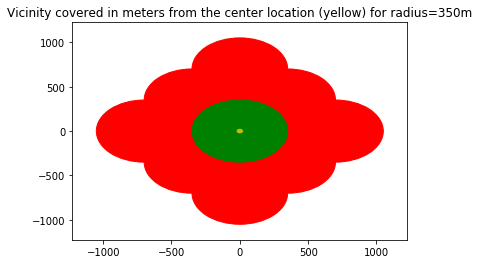

In [8]:
plot_surroundings(radius=350, title='Vicinity covered in meters from the center location (yellow) for radius=350m' )

In [9]:
def get_nearby_venues(names, latitudes, longitudes, radius=500, limit=50, intent='browse', categories=None):
    '''
    @param categories list of Foursquare category identifiers
    '''
    venues_list=[]
    venues_ids=[]
    print('Now getting venues for:')
    for name, lat_museum, long_museum in zip(names, latitudes, longitudes):
        print('-', name)
        
        # We need more results than the limit=50 that FourSquare sets, so we search surrounding points
        for lat, lng in surround(lat_museum, long_museum, radius):
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                limit,
                intent
            )
        
            if categories:
                url = url + "&categoryId={}".format(','.join(categories))
                    
            # make the GET request
            results = requests.get(url).json()["response"]['venues']
        
            if results:            
                # print all categories
                for v in results:
                    if len(v['categories']) > 1:
                        print(v['categories'])
            
                # return only relevant information for each nearby venue
                for v in results:
                    if not v['id'] in venues_ids:
                        venues_ids.append(v['id'])
                        venues_list.append([(
                            name, 
                            lat, 
                            lng, 
                            v['name'],
                            v['id'],
                            v['location']['lat'], 
                            v['location']['lng'],
                            v['location']['distance'],
                            v['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Museum', 
                             'Museum Latitude',
                             'Museum Longitude',
                             'Venue',
                             'Venue id',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Distance',
                             'Venue Category']
    
    with open('nearby_venues_{}.pickle'.format(radius),'wb') as f:
        pickle.dump(nearby_venues, f)
    
    return(nearby_venues)

### Set a mask for museums to be loaded

In [10]:
test = False # Set to True to read data on one location, so as to limit calls to FourSquare while testing
mask = museum_locations['Museum'].isin(list(museum_addresses_input.keys())) # read all
if test:
    mask = museum_locations['Museum'].isin(['Rijksmuseum, Amsterdam']) 
museum_locations[mask].head()

,Museum,Input Address,Address,Latitude,Longitude
0,"Rijksmuseum, Amsterdam","Museumstraat 1, 1071 XX, Amsterdam","Rijksmuseumgebouw, 1, Museumstraat, Nieuwe Pij...",52.359993,4.885349
1,"Prado Museum, Madrid","Paseo del Prado, s/n, 28014, Madrid","Paseo del Prado, Cortes, Centro, Madrid, Área ...",40.411416,-3.693020
2,"Uffizi Gallery, Florence","Piazzale degli Uffizi 6, 50122, Florence","Galleria degli Uffizi, 6, Piazzale degli Uffiz...",43.768313,11.255801
3,Museum of Warsaw,"Rynek Starego Miasta 28-42, 00-272 Warszawa","Rynek Starego Miasta, II, Śródmieście, Warszaw...",52.249832,21.012127
4,"National Museum of the Azulejo, Lisbon",NaN,NaN,38.724633,-9.115996


In [11]:
# --- Configuration here ---
# NOTA BENE: the here defined 'radius' is used to define a vicity that coveres a radius that is actually at least twice as large. See above.
radius = 350
# --- end configuration ---
nearby_venues = None
try:
    with open('nearby_venues_{}.pickle'.format(radius), 'rb') as f:
        print('Reading nearby venues from file')
        nearby_venues = pickle.load(f)
except:
    print('No pickle file found for nearby venues, reading venues from Foursquare')
    nearby_venues = get_nearby_venues(names=museum_locations[mask].Museum,
                                    latitudes=museum_locations[mask].Latitude,
                                    longitudes=museum_locations[mask].Longitude,
                                    radius=radius,
                                    categories=list(wanted_categories.values())
                                    )
        
print("Having {} museum centered locations around Europe.".format(museum_locations.shape[0]))
print('Found {} venues'.format(nearby_venues.shape[0]))
nearby_venues.head()

Reading nearby venues from file
Having 28 museum centered locations around Europe.
Found 5554 venues


,Museum,Museum Latitude,Museum Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Distance,Venue Category
0,"Rijksmuseum, Amsterdam",52.359993,4.885349,Hard Rock Cafe Amsterdam,4a26ff64f964a5206a7f1fe3,52.362065,4.883073,277,Theme Restaurant
1,"Rijksmuseum, Amsterdam",52.359993,4.885349,Back to Black,5390600e498ea928667afb97,52.361020,4.888569,246,Coffee Shop
2,"Rijksmuseum, Amsterdam",52.359993,4.885349,MOMO,4a954c2ef964a520e02220e3,52.361597,4.882537,261,Asian Restaurant
3,"Rijksmuseum, Amsterdam",52.359993,4.885349,RIJKS®,54554897498eb158b5e3a110,52.359542,4.884451,79,Molecular Gastronomy Restaurant
4,"Rijksmuseum, Amsterdam",52.359993,4.885349,Hans & Grietje,4a270034f964a520a7821fe3,52.361649,4.887152,221,Café


### Check limit

We had set a limit to the number of venues returned from the FourSquare query. Is this limit reasonable?
Let's see how many venues are returned for each museum.

In [12]:
nearby_venues[['Museum','Venue']].groupby('Museum').count()

,Venue
Museum,
"Acropolis Museum, Athens",166
"DDR Museum, Berlin",263
"Hermitage Museum, St. Petersburg",163
"Latvian National Museum of Art, Riga",267
"Musee Louvre, Paris",244
Musee d'Art Comtemporani de Barcelona,271
"Museu Coleção Berardo, Lisbon",157
"Museum Ludwig, Cologne",162
Museum of Warsaw,195


### Filter out any venue that is not a restaurant

In [13]:
restaurants = nearby_venues[nearby_venues['Venue Category'].str.contains('Restaurant')]
print("Found {} venues after filter out those without 'Restaurant' in category".format(restaurants.shape[0]))

Found 2468 venues after filter out those without 'Restaurant' in category


### Check if we actually found a significant number of restaurants for every museum location
Display histogram and the number of restaurants in ascending order of each of the museum locations.

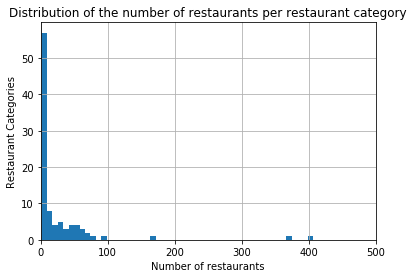

In [14]:
r = restaurants[['Venue Category','Venue']].groupby('Venue Category').count().sort_values(by='Venue', ascending=False)
r.hist('Venue', bins=50)
plt.xlim(xmin=0,xmax=500)  # this line
plt.title('Distribution of the number of restaurants per restaurant category')
plt.xlabel('Number of restaurants')
plt.ylabel('Restaurant Categories')
plt.show()

How should we interpret this histogram? It tells us that:
* In the vast majority of restaurant types we find only up to 10 restaurants all over our dataset
* Three restaurant types have more than 100 restaurants and two of them several hundred.

Hence, the number of restaurants is distributed very unequally over restaurant types.

In [15]:
q = restaurants[['Museum','Venue']].groupby('Museum').count().sort_values('Venue',ascending=True)
q

,Venue
Museum,
"Viking Ship Museum, Roskilde",16
"National Museum of the Azulejo, Lisbon",19
"Statens Museum for Kunst, Copenhagen",31
"Picasso Museum, Barcelona",39
"Acropolis Museum, Athens",55
"Pushkin Museum of Fine Art, Moscow",63
"Vatican Museums, Rome",73
"Museu Coleção Berardo, Lisbon",78
"Musée d'Orsay, Paris",78


Let's visualize the distribution of venues per area.

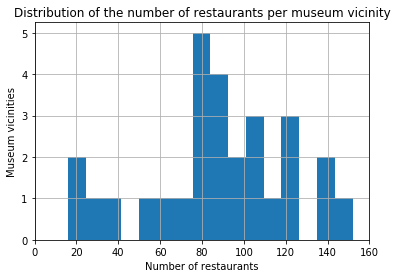

In [16]:
q.hist(bins=16)
plt.xlim(xmin=0,xmax=160)  # this line
plt.title('Distribution of the number of restaurants per museum vicinity')
plt.xlabel('Number of restaurants')
plt.ylabel('Museum vicinities')
plt.show()

From the above histogram we learn that the number of venues per area is relatively centered at around 90. This seems like a reasonable basis for continuing the investigation according to the plan set out in the methodology.

Let's have a look at the data we have now.

In [17]:
restaurants.head()

,Museum,Museum Latitude,Museum Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Distance,Venue Category
0,"Rijksmuseum, Amsterdam",52.359993,4.885349,Hard Rock Cafe Amsterdam,4a26ff64f964a5206a7f1fe3,52.362065,4.883073,277,Theme Restaurant
2,"Rijksmuseum, Amsterdam",52.359993,4.885349,MOMO,4a954c2ef964a520e02220e3,52.361597,4.882537,261,Asian Restaurant
3,"Rijksmuseum, Amsterdam",52.359993,4.885349,RIJKS®,54554897498eb158b5e3a110,52.359542,4.884451,79,Molecular Gastronomy Restaurant
5,"Rijksmuseum, Amsterdam",52.359993,4.885349,wagamama,4a2707a2f964a520778e1fe3,52.362287,4.882874,305,Asian Restaurant
8,"Rijksmuseum, Amsterdam",52.359993,4.885349,Levant,4a27080cf964a5209b8f1fe3,52.360947,4.887001,154,Turkish Restaurant


In [18]:
restaurants.shape

(2468, 9)

## Venue categories

What venue categories - types of restaurants - do we now have in our dataset?

Below we first display this in a table, then in a histogram

In [19]:
category_overview = restaurants[['Venue Category','Venue']].groupby('Venue Category',as_index=False).count().\
    sort_values(by='Venue', ascending=False)
category_overview.head(10)

,Venue Category,Venue
45,Italian Restaurant,407
70,Restaurant,368
35,French Restaurant,168
33,Fast Food Restaurant,97
6,Asian Restaurant,78
84,Tapas Restaurant,68
80,Sushi Restaurant,68
79,Spanish Restaurant,65
75,Seafood Restaurant,63
47,Japanese Restaurant,62


In [20]:
def display_categories(df, top=20, title='in our dataset'):
    plt.rcdefaults()
    ndf = df.copy().reindex(index=df.index[::-1])
    fig, ax = plt.subplots()
    ax.set_title('Top {} restaurant categories {}'.format(top, title))
    
    ndf[-1*top:].plot.barh(x='Venue Category', y='Venue', ax=ax, legend=False)
    plt.xlabel('Number of restaurants')
    plt.ylabel('')
    plt.show()

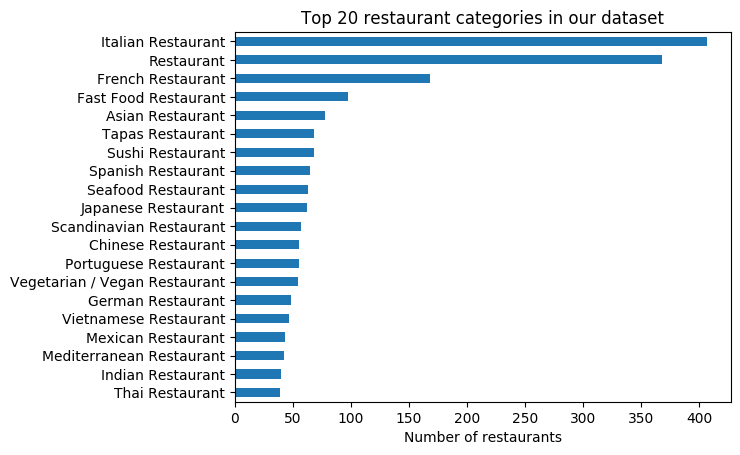

In [21]:
display_categories(category_overview, top=20, title='in our dataset')

## Venue categories per museum

In [22]:
# one hot encoding
restaurants_onehot = pd.get_dummies(restaurants[['Venue Category']], prefix="", prefix_sep="")

# add museum column back to dataframe
restaurants_onehot['Museum'] = restaurants['Museum'] 

# move neighborhood column to the first column
fixed_columns = [restaurants_onehot.columns[-1]] + list(restaurants_onehot.columns[:-1])
restaurants_onehot = restaurants_onehot[fixed_columns]

restaurants_onehot.head()

,Museum,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Auvergne Restaurant,Basque Restaurant,Bavarian Restaurant,Belgian Restaurant,Bosnian Restaurant,Brazilian Restaurant,Breton Restaurant,Bulgarian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Rhenisch Restaurant,Roman Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Slovak Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swabian Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tatar Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,"Rijksmuseum, Amsterdam",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,"Rijksmuseum, Amsterdam",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Rijksmuseum, Amsterdam",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Rijksmuseum, Amsterdam",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,"Rijksmuseum, Amsterdam",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [23]:
restaurants_grouped = restaurants_onehot.groupby('Museum').mean().reset_index()
restaurants_grouped.head()

,Museum,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Auvergne Restaurant,Basque Restaurant,Bavarian Restaurant,Belgian Restaurant,Bosnian Restaurant,Brazilian Restaurant,Breton Restaurant,Bulgarian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Rhenisch Restaurant,Roman Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Slovak Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swabian Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tatar Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,"Acropolis Museum, Athens",0.000000,0.000000,0.000000,0.018182,0.0,0.0,0.036364,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.018182,0.036364,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.018182,0.0,0.000000,0.000000,0.0,0.418182,0.072727,0.0,0.0,0.072727,0.0,0.0000,0.072727,0.0,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.0,0.018182,0.036364,0.018182,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.072727,0.000000,0.0,0.000000,0.000000,0.018182,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.018182,0.0000,0.000000,0.0,0.000000,0.0,0.018182,0.0,0.000000
1,"DDR Museum, Berlin",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.025424,0.0,0.000000,0.000000,0.008475,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.008475,0.016949,0.000000,0.0,0.000000,0.0,0.025424,0.000000,0.0,0.000000,0.0,0.008475,0.000000,0.033898,0.0,0.008475,0.262712,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.093220,0.0,0.033898,0.008475,0.008475,0.008475,0.008475,0.000000,0.0,0.000000,0.025424,0.000000,0.016949,0.008475,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.008475,0.110169,0.008475,0.0,0.000000,0.000000,0.008475,0.0,0.0,0.0,0.008475,0.042373,0.008475,0.0,0.000000,0.008475,0.0,0.016949,0.0000,0.008475,0.0,0.000000,0.0,0.033898,0.0,0.127119
2,"Hermitage Museum, St. Petersburg",0.012500,0.000000,0.000000,0.000000,0.0,0.0,0.050000,0.0,0.000000,0.000000,0.000000,0.025000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.062500,0.037500,0.012500,0.0,0.012500,0.0,0.025000,0.000000,0.0,0.012500,0.0,0.000000,0.000000,0.062500,0.0,0.000000,0.012500,0.0,0.000000,0.000000,0.0,0.0,0.037500,0.0,0.0125,0.162500,0.0,0.025000,0.000000,0.000000,0.037500,0.000000,0.000000,0.0,0.025000,0.000000,0.000000,0.000000,0.050000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012500,0.150000,0.000000,0.0,0.087500,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.025000,0.000000,0.0,0.000000,0.012500,0.0,0.000000,0.0125,0.000000,0.0,0.000000,0.0,0.025000,0.0,0.000000
3,"

### Let's see what the current size is

In [24]:
restaurants_grouped.shape

(28, 96)

### Putting the most popular restaurants per area in a dataframe

We put the most popular restaurants as columns in a dataframe.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Museum']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
museums_venues_sorted = pd.DataFrame(columns=columns)
museums_venues_sorted['Museum'] = restaurants_grouped['Museum']

for ind in np.arange(restaurants_grouped.shape[0]):
    museums_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_grouped.iloc[ind, :], num_top_venues)

museums_venues_sorted.head()

,Museum,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,"Acropolis Museum, Athens",Greek Restaurant,Italian Restaurant,Grilled Meat Restaurant,Indian Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Comfort Food Restaurant,Japanese Restaurant,Seafood Restaurant,Kebab Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Meze Restaurant,Chinese Restaurant
1,"DDR Museum, Berlin",German Restaurant,Vietnamese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Asian Restaurant,Doner Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bavarian Restaurant
2,"Hermitage Museum, St. Petersburg",Italian Restaurant,Restaurant,Russian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Modern European Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,Korean Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Belgian Restaurant,Doner Restaurant
3,"Latvian National Museum of Art, Riga",Restaurant,Eastern European Restaurant,American Restaurant,Italian Restaurant,Sushi Restaurant,Kebab Restaurant,Seafood Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Russian Restaurant,Indian Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant
4,"Musee Louvre, Paris",French Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Restaurant,Seafood Restaurant,Udon Restaurant,Korean Restaurant,Alsatian Restaurant,Chinese Restaurant,Lebanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Tapas Restaurant


# 3. Cluster museums

### Preliminaries: cluster and present

Before actually doing any clustering of neighbourhoods, let's define methods for:
1. Clustering
2. Presenting the result of clustering on a map
3. Evaluate the clusters

In [27]:
def cluster_museums(kclusters):
    '''Cluster neighbourhoods in kcluster groups'''
    restaurants_grouped_clustering = restaurants_grouped.drop('Museum', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_
    
    # add clustering labels
    nvs = museums_venues_sorted.copy()
    nvs.insert(0, 'Cluster Labels', kmeans.labels_)
    
    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    museums_merged = pd.merge(museum_locations, nvs.set_index('Museum'), on='Museum')

    cluster_counts = museums_merged[['Museum', 'Cluster Labels']].groupby("Cluster Labels").count().sort_values(by='Museum', ascending=False)
    cluster_counts.reset_index()
    return museums_merged, cluster_counts

In [28]:
def evaluate_clusters(cluster_counts, restaurants_onehot, museums_merged):
    num_top_venues = 5
        
    clustered_onehot = pd.merge(restaurants_onehot, museums_merged[['Museum', 'Cluster Labels']], 
                            how='left', on='Museum')
    restaurants_grouped_clusters = clustered_onehot.groupby('Cluster Labels').mean().reset_index()

    rows = int(cluster_counts.shape[0]/2)+cluster_counts.shape[0]%2
    cols = 2
    fig_dims = (7*cols, 5*rows)
    fig, axes = plt.subplots(rows, cols, figsize=fig_dims)
    fig.tight_layout(w_pad=11.0, h_pad=4.0)

    i=0
    for cluster_id, freq in cluster_counts.itertuples():
        mask = restaurants_grouped_clusters['Cluster Labels'] == cluster_id
        temp = restaurants_grouped_clusters[mask].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        showframe = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
        mask2 = showframe['freq'] > 0.0
        # Remove all items with frequency zero
        showframe = showframe[mask2]
        # Reindex to reverse the order as we want top frequency shown at the top of the barchart
        showframe = showframe.reindex(index=showframe.index[::-1])
        # Prevent autoscale from making fewer bars in any chart become extra width
        width = (0.8 * showframe.shape[0] / 5) - (5-showframe.shape[0])*0.01
        title = "Cluster {}: {} museums".format(cluster_id, freq)
        c = 'blue'
        m = museums_merged['Cluster Labels'] == cluster_id
        if freq > 0 and freq <= 3:
            name = ''
            try:
                name = ' | '.join(list(map(lambda x: x.split(',')[0], museums_merged[m]['Museum'].to_list())))
            except:
                name = ' | '.join(list(map(lambda x: x.split(',')[0], museums_merged[m]['Museum'].values)))
            c = 'green'
            designation = ''
            if freq == 1:
                designation = 'outlier'
            elif freq == 2:
                designation = 'pair'
            elif freq == 3:
                designation = 'triplet'
            title = "Cluster {}: {}: {}".format(cluster_id, designation, name)
        print("Cluster {}: ".format(cluster_id), " | ".join(museums_merged[m]['Museum'].tolist()))
        cur_ax = axes[int(i/2), i%2]
        showframe.plot(ax=cur_ax, kind='barh',y='freq', x='venue', width=width, color=c, legend=False)
        cur_ax.set_title(title)
        cur_ax.set_xlim(right=1.0)
        cur_ax.yaxis.set_label_text("")
        i=i+1
    # If the number of plot is odd, we need to remove the last axes slot
    if cluster_counts.shape[0] % 2 != 0:
        fig.delaxes(axes[rows-1, 1])

## Evaluate clusters

Here we set the number of clusters we want to distinguish, use K-means to cluster areas (museums), and evaluate the characteristics of each cluster.

In [29]:
# Form the clusters using K-means clustering algorithm
kclusters = 7
museums_merged, cluster_counts = cluster_museums(kclusters)

### Cluster characteristics

Below we evaluate clusters. The clusters are labelled by a number. 
For reference, first we list what locations ("museums") are part of each cluster. Second we display a barchart of the five most prevalent restaurant categories in each cluster.

For quick scanning, the bars are colored:
* **blue** in clusters with a significant number of elements
* **green** for clusters with only a few elements.

Cluster 0:  Rijksmuseum, Amsterdam | Museum of Warsaw | Hermitage Museum, St. Petersburg | National Gallery, London | DDR Museum, Berlin | Tate Modern, London | Museum Ludwig, Cologne | Musée d'Art et de Histoire, Genève | The Rosengard Collection, Lucerne | National Gallery Prague, Prague | Pushkin Museum of Fine Art, Moscow | Statens Museum for Kunst, Copenhagen | The Bohdan and Varvara Khanenko National Museum of Arts, Kiev | Latvian National Museum of Art, Riga
Cluster 2:  Uffizi Gallery, Florence | Vatican Museums, Rome | Peggy Guggenheim Museum, Venice
Cluster 4:  Prado Museum, Madrid | Picasso Museum, Barcelona | Musee d'Art Comtemporani de Barcelona
Cluster 5:  Vasa Museum, Stockholm | Viking Ship Museum, Roskilde | Thorvaldsens Museum, Copenhagen
Cluster 1:  Musee Louvre, Paris | Musée d'Orsay, Paris
Cluster 3:  National Museum of the Azulejo, Lisbon | Museu Coleção Berardo, Lisbon
Cluster 6:  Acropolis Museum, Athens


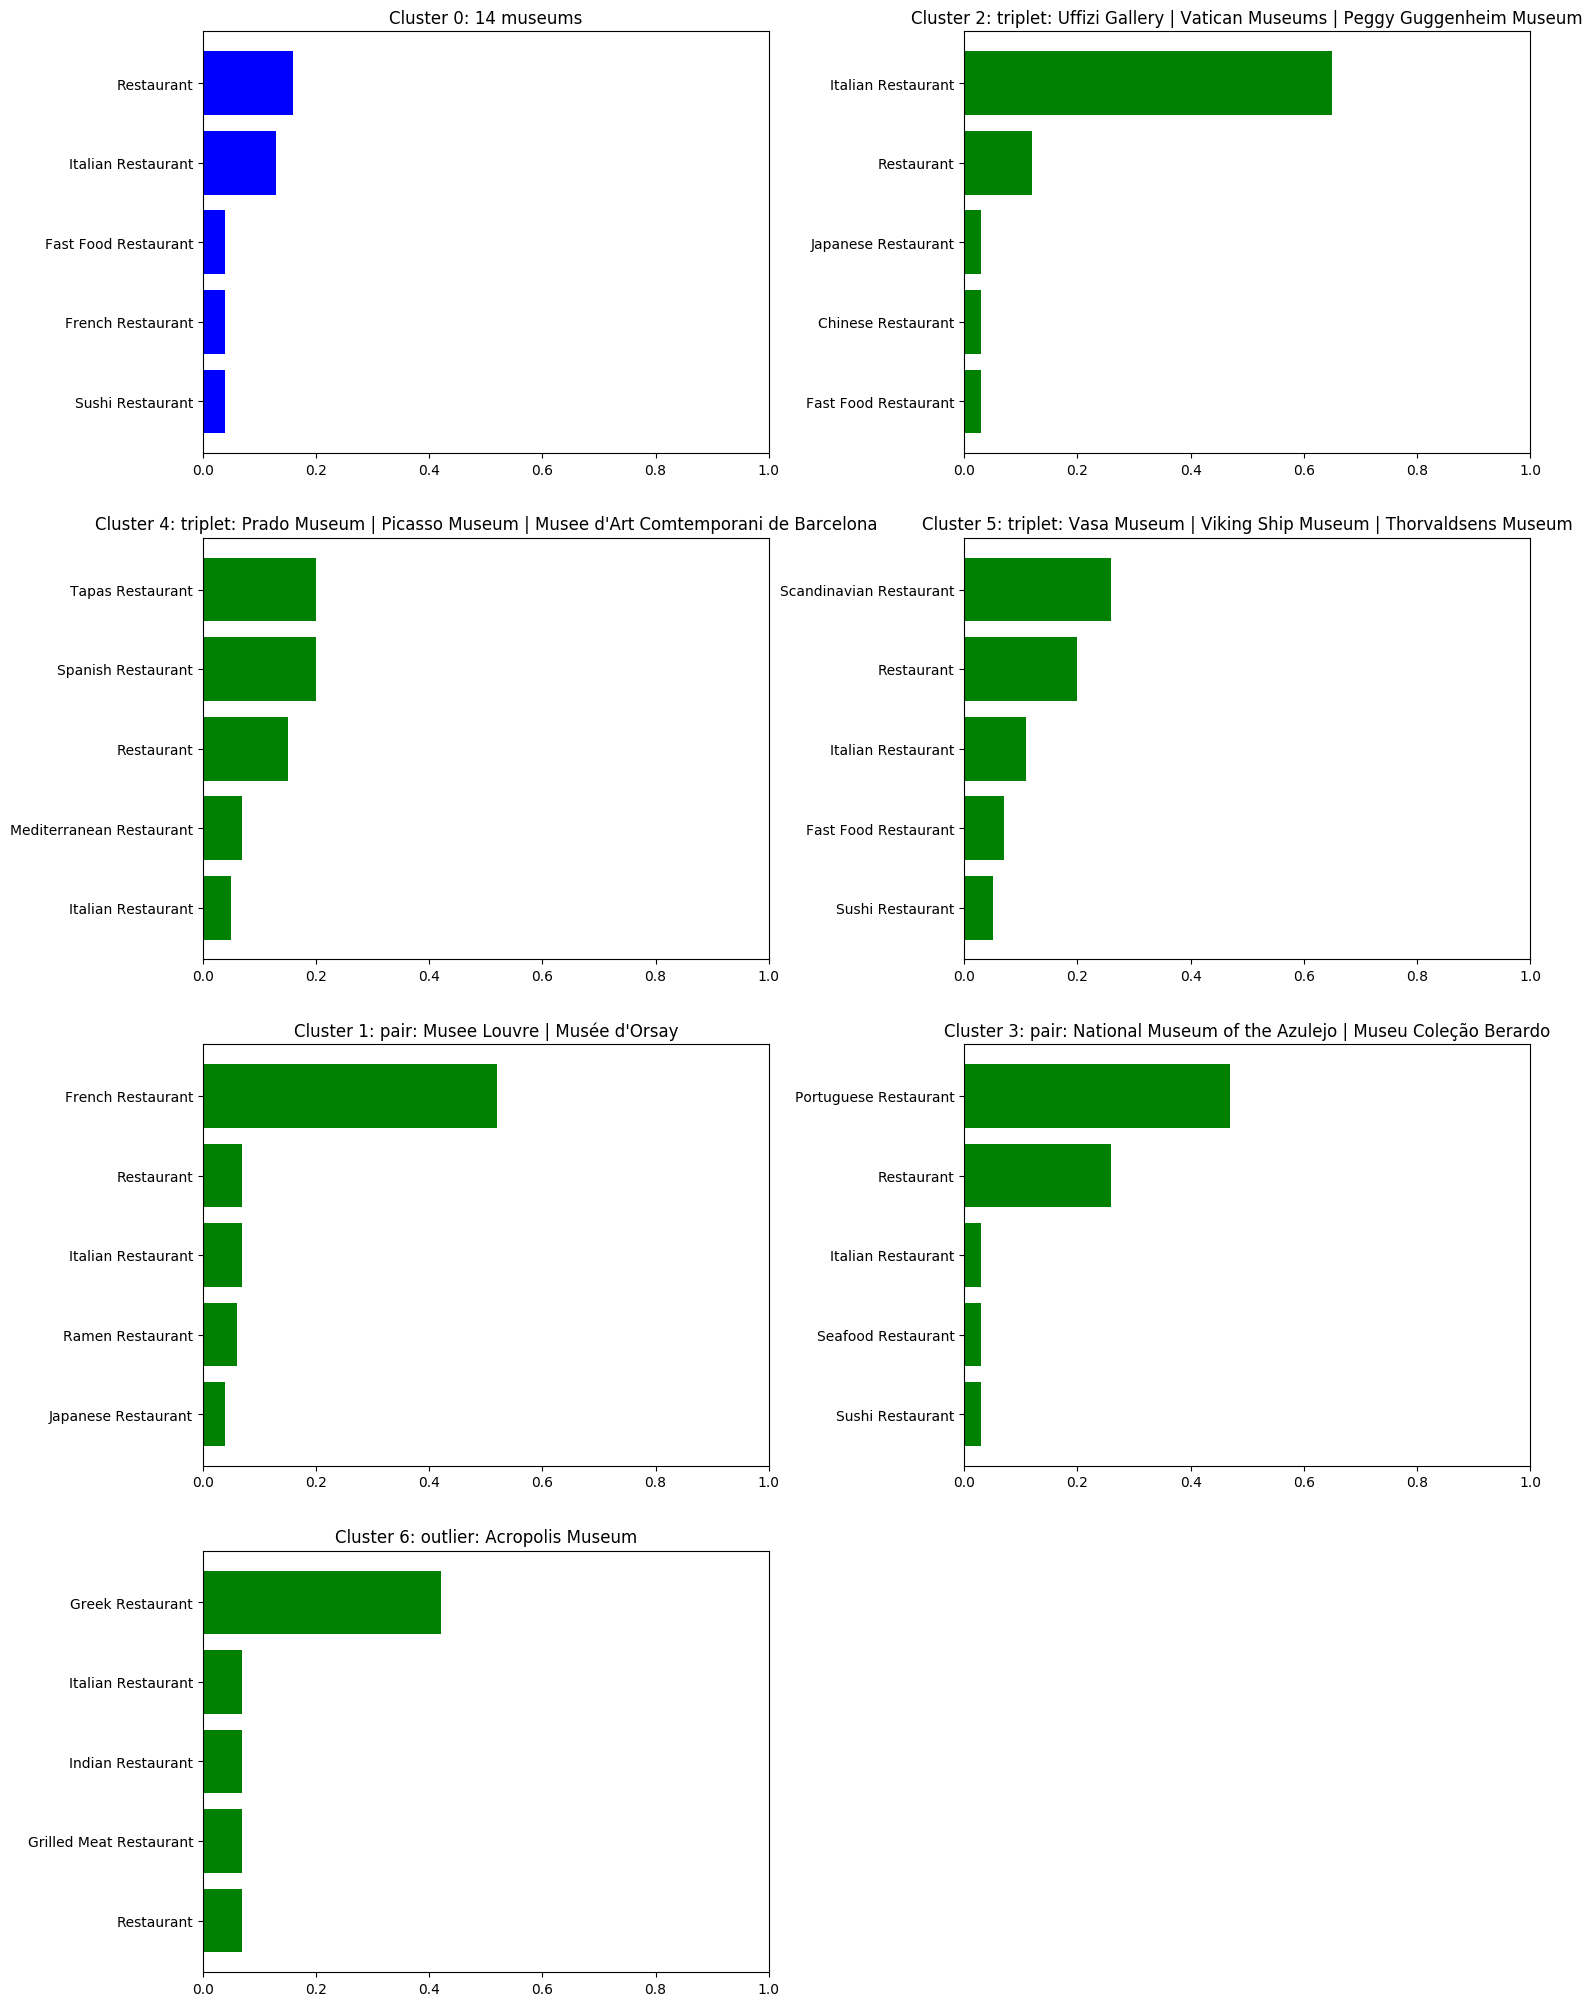

In [30]:
evaluate_clusters(cluster_counts, restaurants_onehot, museums_merged)

In [31]:
museums_merged.head()

,Museum,Input Address,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,"Rijksmuseum, Amsterdam","Museumstraat 1, 1071 XX, Amsterdam","Rijksmuseumgebouw, 1, Museumstraat, Nieuwe Pij...",52.359993,4.885349,0,Italian Restaurant,Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Fast Food Restaurant,French Restaurant,Indonesian Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant
1,"Prado Museum, Madrid","Paseo del Prado, s/n, 28014, Madrid","Paseo del Prado, Cortes, Centro, Madrid, Área ...",40.411416,-3.693020,4,Spanish Restaurant,Restaurant,Tapas Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Turkish Restaurant,Italian Restaurant,Peruvian Restaurant,Argentinian Restaurant,Thai Restaurant,Modern European Restaurant,Paella Restaurant
2,"Uffizi Gallery, Florence","Piazzale degli Uffizi 6, 50122, Florence","Galleria degli Uffizi, 6, Piazzale degli Uffiz...",43.768313,11.255801,2,Italian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Tuscan Restaurant,Seafood Restaurant,American Restaurant,Fast Food Restaurant,Ramen Restaurant,Tapas Restaurant,Falafel Restaurant,Chinese Restaurant,Venezuelan Restaurant,Gluten-free Restaurant,Dutch Restaurant,Cuban Restaurant
3,Museum of Warsaw,"Rynek Starego Miasta 28-42, 00-272 Warszawa","Rynek Starego Miasta, II, Śródmieście, Warszaw...",52.249832,21.012127,0,Polish Restaurant,Restaurant,Eastern European Restaurant,Italian Restaurant,Dumpling Restaurant,Sushi Restaurant,Asian Restaurant,Molecular Gastronomy Restaurant,Chinese Restaurant,American Restaurant,Modern European Restaurant,Doner Restaurant,Bosnian Restaurant,Mexican Restaurant,Kebab Restaurant
4,"National Museum of the Azulejo, Lisbon",NaN,NaN,38.724633,-9.115996,3,Portuguese Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Italian Restaurant,Halal Restaurant,Grilled Meat Restaurant,Czech Restaurant,Indonesian Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant


In [32]:
# Let's create a method to create the map, so we can call it again
# add markers to map
def cluster_map(center_location, latitude_series, longitude_series, name_series, type_series=None, zoom_start=11):
    map = folium.Map(location=center_location, zoom_start=zoom_start)
    if type_series is not None:
        types = type_series.unique().tolist()
        colors_array = cm.rainbow(np.linspace(0, 1, len(types)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]
        for lat, lng, name, typ in zip(latitude_series, longitude_series, name_series, type_series):
            label = name
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=rainbow[types.index(typ)],
                fill=True,
                fill_color=rainbow[types.index(typ)],
                fill_opacity=0.7,
                parse_html=False).add_to(map)
    else:
        for lat, lng, name in zip(latitude_series, longitude_series, name_series):
            label = folium.Popup(name, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='b',
                fill=True,
                fill_color='b',
                fill_opacity=0.7,
                parse_html=False).add_to(map)
            
    return map

### Centering our map

To draw our map we must first determine the center of our locations.

In [33]:
def get_center(df,latitude='Latitude', longitude='Longitude'):
    '''Get the center of all locations to be mapped'''
    max_latitude = df[latitude].max()
    min_latitude = df[latitude].min()
    max_longitude = df[longitude].max()
    min_longitude = df[longitude].min()
    
    return (max_latitude+min_latitude)/2, (max_longitude+min_longitude)/2

center_latitude, center_longitude = get_center(museums_merged, latitude='Latitude', longitude='Longitude')
print('The geograpical coordinates of the center are {}, {}.'.format(center_latitude, center_longitude))

The geograpical coordinates of the center are 48.953831075, 14.198282613271108.


### Drawing the clusters

Let's draw the clusters we found on a map.

In [34]:
cluster_map(
    (center_latitude, center_longitude),
    museums_merged['Latitude'],
    museums_merged['Longitude'],
    museums_merged['Museum'],
    type_series=museums_merged['Cluster Labels'],
    zoom_start=4
)

### Get all museums in the same cluster as the Riga National Art Gallery

First get the cluster label of the Riga National Art Gallery, then select the other museums
that are part of the same cluster.

In [35]:
riga_cluster_label = museums_merged[museums_merged['Museum'] == lnma_riga]['Cluster Labels'].tolist()[0]

In [36]:
riga_cluster = museums_merged[museums_merged['Cluster Labels'] == riga_cluster_label]
riga_cluster.reset_index(inplace=True)
riga_cluster.head()

,index,Museum,Input Address,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,0,"Rijksmuseum, Amsterdam","Museumstraat 1, 1071 XX, Amsterdam","Rijksmuseumgebouw, 1, Museumstraat, Nieuwe Pij...",52.359993,4.885349,0,Italian Restaurant,Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Fast Food Restaurant,French Restaurant,Indonesian Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant
1,3,Museum of Warsaw,"Rynek Starego Miasta 28-42, 00-272 Warszawa","Rynek Starego Miasta, II, Śródmieście, Warszaw...",52.249832,21.012127,0,Polish Restaurant,Restaurant,Eastern European Restaurant,Italian Restaurant,Dumpling Restaurant,Sushi Restaurant,Asian Restaurant,Molecular Gastronomy Restaurant,Chinese Restaurant,American Restaurant,Modern European Restaurant,Doner Restaurant,Bosnian Restaurant,Mexican Restaurant,Kebab Restaurant
2,7,"Hermitage Museum, St. Petersburg","Palace Square, 2, St Petersburg, Russia","Дворцовая площадь, Дворцовый округ, Центральны...",59.939095,30.315697,0,Italian Restaurant,Restaurant,Russian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Modern European Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,Korean Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Belgian Restaurant,Doner Restaurant
3,10,"National Gallery, London","Trafalgar Square, United Kingdom","Trafalgar Square, St. James's, City of Westmin...",51.508037,-0.128049,0,Restaurant,Italian Restaurant,French Restaurant,Japanese Restaurant,Ramen Restaurant,Fast Food Restaurant,Indian Restaurant,English Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,Seafood Restaurant,Portuguese Restaurant,Dim Sum Restaurant,Asian Restaurant
4,11,"DDR Museum, Berlin","Karl-Liebknecht-Str. 1, 10178 Berlin, Germany","DDR-Museum, 1, Karl-Liebknecht-Straße, Mitte, ...",52.519440,13.402238,0,German Restaurant,Vietnamese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Asian Restaurant,Doner Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bavarian Restaurant


# 4. Compare Riga with the rest of the cluster it is part of

Let's take the *Riga National Gallery* out of the set, so we can compare the venue categories in Riga
with those in the rest of the cluster it is part of.

In [37]:
riga_museum = riga_cluster[riga_cluster['Museum'] == lnma_riga]
riga_cluster = riga_cluster[riga_cluster['Museum'] != lnma_riga]
riga_cluster.head()

,index,Museum,Input Address,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,0,"Rijksmuseum, Amsterdam","Museumstraat 1, 1071 XX, Amsterdam","Rijksmuseumgebouw, 1, Museumstraat, Nieuwe Pij...",52.359993,4.885349,0,Italian Restaurant,Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Fast Food Restaurant,French Restaurant,Indonesian Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant
1,3,Museum of Warsaw,"Rynek Starego Miasta 28-42, 00-272 Warszawa","Rynek Starego Miasta, II, Śródmieście, Warszaw...",52.249832,21.012127,0,Polish Restaurant,Restaurant,Eastern European Restaurant,Italian Restaurant,Dumpling Restaurant,Sushi Restaurant,Asian Restaurant,Molecular Gastronomy Restaurant,Chinese Restaurant,American Restaurant,Modern European Restaurant,Doner Restaurant,Bosnian Restaurant,Mexican Restaurant,Kebab Restaurant
2,7,"Hermitage Museum, St. Petersburg","Palace Square, 2, St Petersburg, Russia","Дворцовая площадь, Дворцовый округ, Центральны...",59.939095,30.315697,0,Italian Restaurant,Restaurant,Russian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Modern European Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,Korean Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Belgian Restaurant,Doner Restaurant
3,10,"National Gallery, London","Trafalgar Square, United Kingdom","Trafalgar Square, St. James's, City of Westmin...",51.508037,-0.128049,0,Restaurant,Italian Restaurant,French Restaurant,Japanese Restaurant,Ramen Restaurant,Fast Food Restaurant,Indian Restaurant,English Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,Seafood Restaurant,Portuguese Restaurant,Dim Sum Restaurant,Asian Restaurant
4,11,"DDR Museum, Berlin","Karl-Liebknecht-Str. 1, 10178 Berlin, Germany","DDR-Museum, 1, Karl-Liebknecht-Straße, Mitte, ...",52.519440,13.402238,0,German Restaurant,Vietnamese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Asian Restaurant,Doner Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bavarian Restaurant


### Let's get back the original data for venues

Get data for the rest of the cluster.

In [38]:
baseline = pd.merge(riga_cluster['Museum'], restaurants_grouped, how='left', on='Museum')
baseline.head()

,Museum,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Auvergne Restaurant,Basque Restaurant,Bavarian Restaurant,Belgian Restaurant,Bosnian Restaurant,Brazilian Restaurant,Breton Restaurant,Bulgarian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Rhenisch Restaurant,Roman Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Slovak Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swabian Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tatar Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,"Rijksmuseum, Amsterdam",0.000000,0.000000,0.0,0.012500,0.000000,0.000000,0.075000,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.025000,0.0000,0.0,0.0000,0.000000,0.000000,0.012500,0.0125,0.000000,0.000000,0.000000,0.000000,0.037500,0.0,0.037500,0.012500,0.0,0.012500,0.0,0.0,0.000000,0.000000,0.0375,0.000000,0.162500,0.000000,0.037500,0.000000,0.000000,0.012500,0.000000,0.012500,0.0,0.050,0.012500,0.0,0.012500,0.000000,0.012500,0.0,0.0,0.0125,0.000000,0.0,0.0,0.0125,0.000000,0.000000,0.037500,0.162500,0.000000,0.0,0.0000,0.0,0.037500,0.000000,0.0,0.0,0.012500,0.025000,0.000000,0.000000,0.0,0.000000,0.0,0.012500,0.012500,0.012500,0.0,0.000000,0.0,0.050000,0.0,0.025000
1,Museum of Warsaw,0.000000,0.010753,0.0,0.021505,0.010753,0.000000,0.021505,0.0,0.0,0.0,0.000000,0.000,0.010753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.021505,0.0000,0.0,0.0000,0.010753,0.010753,0.064516,0.0000,0.129032,0.000000,0.010753,0.010753,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.010753,0.000000,0.0000,0.000000,0.118280,0.000000,0.000000,0.010753,0.010753,0.000000,0.000000,0.000000,0.0,0.000,0.010753,0.0,0.010753,0.021505,0.021505,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0000,0.193548,0.000000,0.000000,0.172043,0.000000,0.0,0.0000,0.0,0.000000,0.010753,0.0,0.0,0.010753,0.021505,0.000000,0.000000,0.0,0.010753,0.0,0.010753,0.010753,0.000000,0.0,0.000000,0.0,0.010753,0.0,0.000000
2,"Hermitage Museum, St. Petersburg",0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.050000,0.0,0.0,0.0,0.000000,0.025,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.037500,0.0125,0.0,0.0125,0.000000,0.025000,0.000000,0.0000,0.012500,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.012500,0.0,0.000000,0.0,0.0,0.000000,0.037500,0.0000,0.012500,0.162500,0.000000,0.025000,0.000000,0.000000,0.037500,0.000000,0.000000,0.0,0.025,0.000000,0.0,0.000000,0.050000,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.012500,0.150000,0.000000,0.0,0.0875,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.025000,0.000000,0.000000,0.0,0.012500,0.0,0.000000,0.012500,

Get data for Riga

In [39]:
riga_baseline = pd.merge(riga_museum['Museum'], restaurants_grouped, how='left', on='Museum')
riga_baseline

,Museum,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Auvergne Restaurant,Basque Restaurant,Bavarian Restaurant,Belgian Restaurant,Bosnian Restaurant,Brazilian Restaurant,Breton Restaurant,Bulgarian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Rhenisch Restaurant,Roman Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Slovak Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swabian Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tatar Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,"Latvian National Museum of Art, Riga",0.009709,0.009709,0.0,0.07767,0.0,0.0,0.029126,0.0,0.0,0.0,0.0,0.009709,0.0,0.0,0.0,0.0,0.009709,0.0,0.0,0.0,0.009709,0.019417,0.009709,0.0,0.009709,0.0,0.0,0.009709,0.0,0.087379,0.0,0.0,0.009709,0.048544,0.0,0.019417,0.0,0.0,0.0,0.0,0.0,0.0,0.019417,0.0,0.0,0.067961,0.0,0.009709,0.009709,0.048544,0.0,0.0,0.0,0.0,0.009709,0.019417,0.0,0.0,0.009709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009709,0.23301,0.0,0.0,0.019417,0.009709,0.048544,0.0,0.0,0.0,0.0,0.048544,0.0,0.0,0.0,0.009709,0.0,0.0,0.0,0.009709,0.0,0.0,0.0,0.029126,0.0,0.019417


In [40]:
number_of_top_categories = 10
top_categories = baseline.mean(axis = 0).sort_values(ascending=False)[:number_of_top_categories]
top_categories = top_categories.to_frame().reset_index()
top_categories.columns = ['Venue Category','Average']
top_categories

,Venue Category,Average
0,Restaurant,0.145156
1,Italian Restaurant,0.129351
2,Fast Food Restaurant,0.044038
3,Asian Restaurant,0.043955
4,Sushi Restaurant,0.038569
5,French Restaurant,0.036277
6,German Restaurant,0.033691
7,Chinese Restaurant,0.031618
8,Thai Restaurant,0.029490
9,Vietnamese Restaurant,0.026024


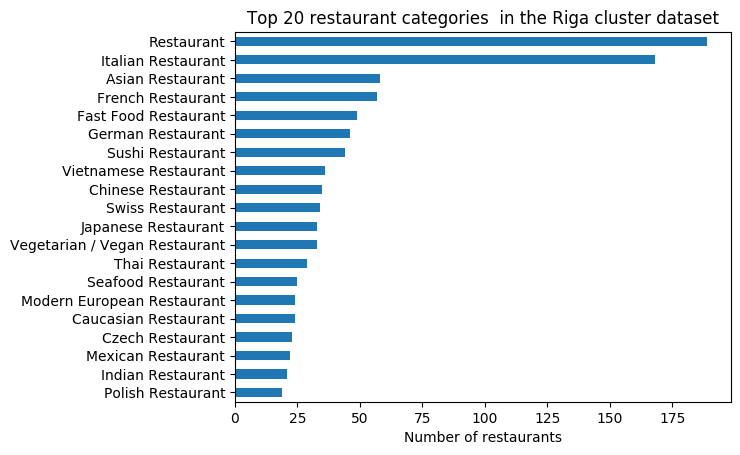

In [41]:
riga_cluster['Museum'].to_list()
cluster_restaurants_mask = restaurants['Museum'].isin(riga_cluster['Museum'].to_list())
r = restaurants[cluster_restaurants_mask]
category_overview2 = r[['Venue Category','Venue']].groupby('Venue Category',as_index=False).count().\
    sort_values(by='Venue', ascending=False)
display_categories(
    category_overview2, top=20, title=' in the Riga cluster dataset'
)

In [42]:
p = (int(category_overview2[category_overview2['Venue Category'] == 'Restaurant']['Venue']) / category_overview2['Venue'].sum())*100
print("{}% of restaurants belong to the generic category 'Restaurant'".format(int(p)))

14% of restaurants belong to the generic category 'Restaurant'


In [43]:
riga_categories = baseline

cluster_restaurants_mask = restaurants['Museum'].isin(riga_cluster['Museum'].to_list())
r = restaurants[cluster_restaurants_mask]### What restaurant categories do we see in Riga?

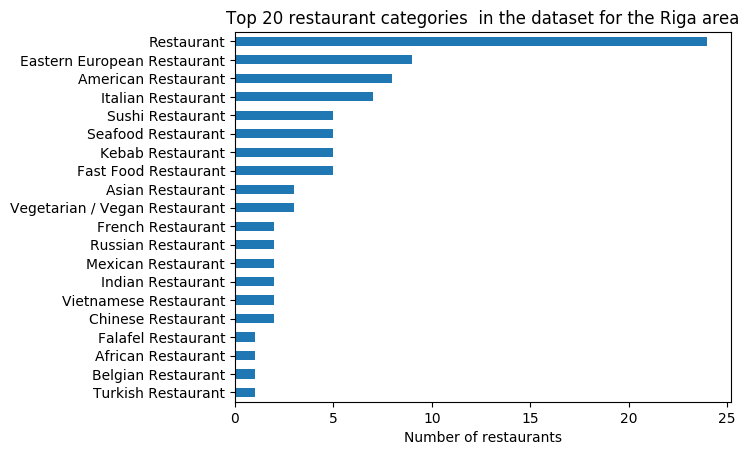

In [44]:
riga_restaurants_mask = restaurants['Museum'] == lnma_riga
r1 = restaurants[riga_restaurants_mask]
category_overview3 = r1[['Venue Category','Venue']].groupby('Venue Category',as_index=False).count().\
    sort_values(by='Venue', ascending=False)
display_categories(
    category_overview3, top=20, title=' in the dataset for the Riga area'
)

In [45]:
print("Total number of restaurants in Riga is: {}".format(r1.shape[0]))

Total number of restaurants in Riga is: 103


### Drop all columns that have an average lower than the top categories

In [46]:
top_categories['Venue Category'].tolist()

['Restaurant',
 'Italian Restaurant',
 'Fast Food Restaurant',
 'Asian Restaurant',
 'Sushi Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Chinese Restaurant',
 'Thai Restaurant',
 'Vietnamese Restaurant']

In [47]:
short_list = baseline[['Museum']+top_categories['Venue Category'].tolist()]
short_list.head()

,Museum,Restaurant,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,French Restaurant,German Restaurant,Chinese Restaurant,Thai Restaurant,Vietnamese Restaurant
0,"Rijksmuseum, Amsterdam",0.162500,0.162500,0.037500,0.075000,0.025000,0.037500,0.012500,0.025000,0.012500,0.025000
1,Museum of Warsaw,0.172043,0.118280,0.000000,0.021505,0.021505,0.000000,0.000000,0.021505,0.010753,0.000000
2,"Hermitage Museum, St. Petersburg",0.150000,0.162500,0.062500,0.050000,0.025000,0.000000,0.012500,0.037500,0.000000,0.000000
3,"National Gallery, London",0.128205,0.111111,0.051282,0.025641,0.034188,0.094017,0.000000,0.008547,0.042735,0.008547
4,"DDR Museum, Berlin",0.110169,0.093220,0.033898,0.025424,0.042373,0.008475,0.262712,0.016949,0.016949,0.127119


In [48]:
top_categories_list = top_categories['Venue Category'].tolist()

In [49]:
import seaborn as sns

In [50]:
def overview_plot(general_df, focus_df,title='Spread of venue categories in cluster'):
    '''
    @param general_df Dataframe containing venue category data on all locations
    @param focus_df Dataframe containing venue category data on the focus location
    '''
    fig_dims = (15, 8)
    fig, ax = plt.subplots(figsize=fig_dims)

    # boxplot or violinplot with seaborn
    bplot=sns.violinplot(
        ax=ax,
        data=general_df,
        width=0.5,
        fliersize=5,
        palette="colorblind")

    bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
    bplot.set_title(title)
 

    # add swarmplot for cluster
    bplot=sns.swarmplot(
            ax=ax,
            data=general_df,
            size=4,
            color='white',
            alpha=0.75)

    # add swarmplot for the focus group
    bplot=sns.swarmplot(
            ax=ax,
            data=focus_df,
            color='red',
            size=8,
            alpha=0.75)

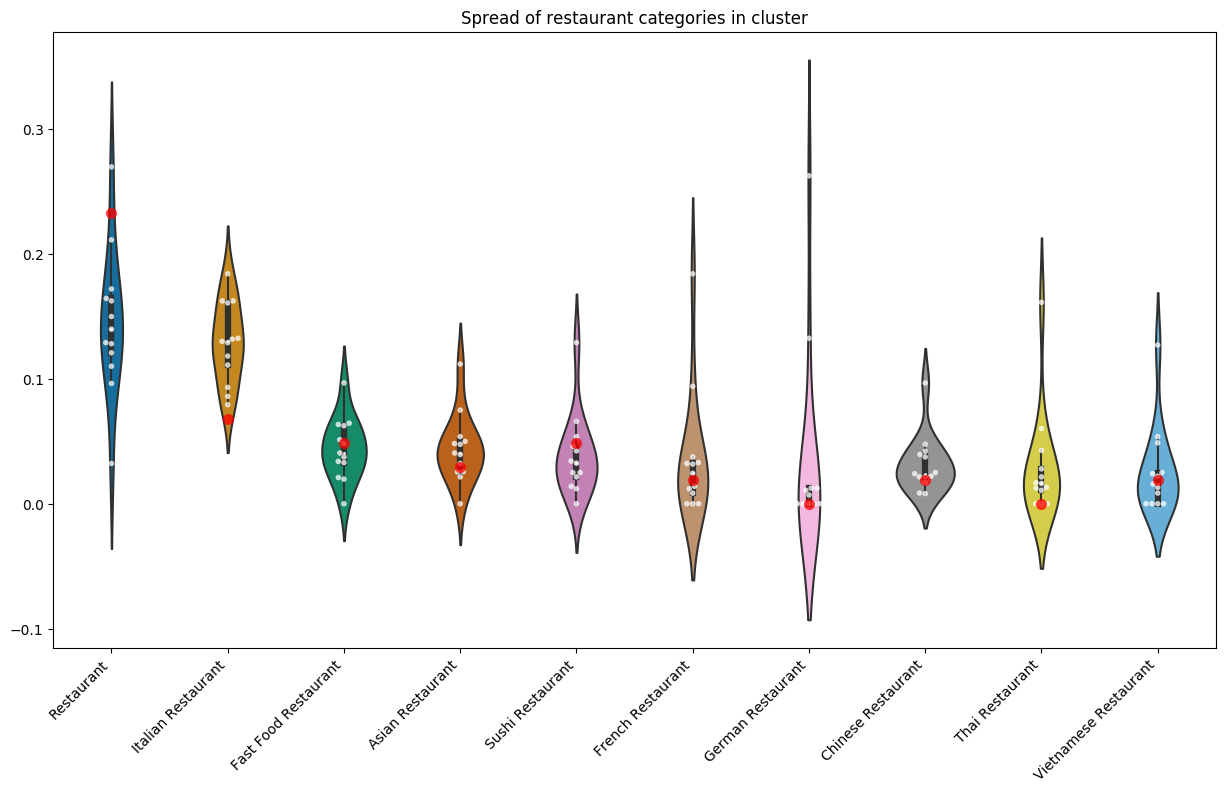

In [51]:
overview_plot(
    short_list[top_categories_list], 
    riga_baseline[top_categories_list],
    title='Spread of restaurant categories in cluster'
)

In the above plot we see:
- violin plot percentages for different restaurants
- swarmplot of the actual values for the different museums from our cluster small dots in white
- actual values for riga large dots in red

# 5. Discussion

## Summary of the methodology

Our goal:

Answer the question of potential entrepreneurs in the restaurant business: 
> *What type of restaurant has a relatively high probability of success in Riga?*

Methodology:
1. Start with a number of areas in Europe comparable with the area of Riga visited by tourists.
2. Get restaurants and their types for all these areas.
3. Cluster the areas to identify those that are similar to Riga
4. Identify the restaurant types that are underrepresented in Riga compared to the rest of the cluster
5. Conclude that those restaurant types have a relatively high probability of success.

## Observations

### Clustering

Clustering of different areas based on the types of restaurants served to identify several areas with strong local cuisines.

Thus we find *national/regional clusters* **dominated by a single type of restaurant**:
* *Italian* restaurant
* *French* restaurant
* *Portuguese* restaurant
* *Greek* restaurant
* *Scandinavian* restaurant
* Tapas / *Spanish* restaurant

We wanted to compare Riga with other areas that are similar and now we find Riga to be in the largest cluster.

We find that the top restaurants in that cluster, less dominating than in the previous ones, are:
1. Italian restaurant
2. "Restaurant"
3. Asian restaurant
4. French restaurant
5. Fast food restaurant

This may be a consequence of the clustering process. If instead of 7 clusters we opt for a division into 13 clusters, not visible straight away in the notebook, obtained by re-setting the parameter in the notebook above, we find some new clusters along the same national cuisine pattern, e.g. *German restaurant* as the primary restaurant near the DDR museum in Berlin and "Polish restaurant' and "Eastern European restaurant" in Warsaw. But we also find that rather than dividing up the larger cluster into national outliers, the smaller - already nationally defined - clusters are cut up further.

Also, the large cluster we found with 7 clusters now gets cut into two parts, with the first having "Italian restaurant" and "Restaurant" as the top two restaurant types and the second with "Restaurant" and "Italian restaurant" as the top two restaurant types.

Quite generally, we find that "Italian restaurant" and "Restaurant" are by far the most common types of restaurants in our dataset.

As similarity doesn't seem to increase significantly by having more clusters a size of 7 has been used for further analysis as this removes the strong national cuisines from the set to compare Riga with.

### Comparison

How does Riga compare to other areas in its cluster? We investigate this by visually comparing the relative presence of restaurant types of the ten most popular restaurant types in the cluster.

Below the comparison of Riga with the other areas in its cluster has been put in a table.

Legend:
* '--' = significantly underrepresented in Riga
* '-' = underrepresented in Riga
* 'o' = Riga is average
* '+' = overrepresented in Riga
* '++' = significantly overrepresented in Riga

|Restaurant type|Comparison|
|---------------|----------|
|Italian restaurant|--|
|"Restaurant"|++|
|Asian restaurant|++|
|Fast Food restaurant|--|
|German restaurant|o|
|French restaurant|+|
|Sushi restaurant|o|
|Thai restaurant|o|
|Seafood restaurant|+|
|Chinese restaurant|o|

### Reconsidering the data

Looking at the table above we can conclude with some confidence that in Riga Italian restaurants and Fast Food restaurants are underrepresented.

However, data on categories is not very informative:
* The 'Restaurant' category is overrepresented. But what is it? A generic restaurant, serving anything, or can it be just any restaurant that could have been categorized more precisely?
* In the top 10 list with find 'Asian restaurant', but also 'Sushi restaurant', 'Thai restaurant', and 'Chinese restaurant'. The latter three categories are all Asian restaurants and could better be presented as a single category.


# Conclusion

> *What type of restaurant has a relatively high probability of success in Riga?*

We found that two kinds of restaurants are underrepresented in Riga compared with other locations where people have relatively similar tastes:
1. Italian restaurants
2. Fast Food restaurants

Additionally, we found that the generic category of "*Restaurant*" is significantly overrepresented in Riga. What are we to make of this? Is a more precise categorization possible? Can it include restaurants with an emphasis on local cuisine, without labelling it e.g. "*Latvian*" or "*Baltic*"? One reason for the absence of such labels may be that they are not currently available in [FourSquare's categorization](https://developer.foursquare.com/docs/resources/categories), so someone would have to introduce them.

In the course of our investigation we found a strong representation of national/regional cuisines in Italy, Spain, Portugal, Greek, and Scandinavia. Given the success of national cuisines elsewhere, the prospective restaurant opener might consider if Riga has more of a market for this, but the present investigation is based on data that fails to identify such a cuisine.

But for the purpose of getting clearer data, and for marketing, restaurant owners in Riga, and in the Baltics generally, might consider branding their cuisine!
